# HOUSING PRICES WITH RIDGE REGRESSION

****************************

##### Davide Riva, Laurea Magistrale in Data Science and Economics

****************

###### I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

### 1. INTRODUCTION

It is well known that Ordinary Least Squares estimation of linear regression coefficients may be exceedingly sensitive to some perturbation in training data. More formally, OLS regression is not stable, a desirable property for a learning algorithm. Assuming a square loss function $l(\mathbf{w}) = (\mathbf{w^{\intercal} x} - y)^{2}$, in which case the OLS estimation is the Empirical Risk Minimizer among linear predictors, a way to stabilize it is to add to the empirical risk a regularization term and then to minimize:

$F_{\alpha}(\mathbf{w}) = \frac{1}{m} \sum_{t=1}^{m} (\mathbf{w^\intercal}\mathbf{x_{t}} - y_{t})^{2} + \alpha \| \mathbf{w} \|_{2}^{2} = \frac{1}{m}\| \mathbf{Xw - y} \|_{2}^{2} + \alpha \| \mathbf{w} \|_{2}^{2}$  

where $\mathbf{X}$ is the $m \times d$ matrix whose rows are samples of the explanatory variables, $\mathbf{y}$ is the vector containing $m$ samples of the target variable and $\alpha$ is a regularization parameter. 

This technique, called Ridge regression, aims at reducing variance error and overfitting, but it necessarely introduces a trade-off between stability and accuracy. In particular, training error will get larger and larger as we move away from empirical risk minimization, resulting in a risk of underfitting. However, test error variance, which is used as a proxy for variance error, should shrink. 

The scope of the present analysis is to apply such a framework to a real dataset, presented in section 2, in order to check for the improvement in stability, possible underfitting and the response of the algorithm to changes in $\alpha$. Accuracy on training data will be measured by the $R^{2}$ coefficient, whereas the test error (MSE) will be presented explicitly. K-fold cross validation will allow both to weaken the dependency of test error on the specific test set and to empirically measure error variance as $s_{K}^{2} = \frac{1}{K-1} \sum_{k=1}^{K} (MSE_{k} - \overline{MSE})^2$, where $MSE_{k}$ is the MSE on the $k$-th fold and $\overline{MSE}$ is the average MSE on all folds. One drawback of cross validation is that training folds overlap and independency among training errors doesn't hold. As a consequence the estimates of the mean training error and its variance may be biased, and in particular variance may be underestimated. Nevertheless, they will be kept as proxies in order to check for overfitting/underfitting and stability of the model.

Two approaches to the minimization of $F_{\alpha}(\mathbf{w})$ will be compared: one is the direct computation of the estimated predictor $\mathbf{\hat{w}}$ using the explicit formula $\mathbf{\hat{w}} = (\mathbf{X^{\intercal}X} +  \alpha m\mathbf{I})^{-1} \mathbf{X^{\intercal}y}$, the other involves gradient descent. In the end, I will analyze the behavior of error when adding quadratic terms and when applying dimension reduction techniques. Section 3 deals with the details, whereas conclusions are summarized in section 4.

### 2. DATA

The data were taken from the California housing dataset, which originally contained 20640 observations of 10 features about houses and their neighborhoods. The median house value within a block of houses was chosen as target (dependent) variable for the regression, whereas the explanatory variables are listed below and the first instances shown in the following table:

- longitude
- latitude
- median age of houses within a block
- number of rooms within a block
- number of bedrooms within a block
- population of the block
- number of households in the block
- median income whithin a block
- area (near bay, near ocean, in an hour from the ocean, inland, island)


In [2]:
dataset = pd.read_csv("cal-housing.csv")
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Plotting a map of instances and the distribution of the target variable, some preliminary observations may be proposed. First of all, houses in the inland generally have lower values than those in other areas, suggesting the ocean proximity categorical variable to be significant, with a negative coefficient for the inland and a positive one for the bay. From this characteristic, also the significance of the longitude feature may be derived, since, other things equal, westernmost houses tend to be more expensive. The same for latitude, with southernmost blocks presenting higher median values.

As for the distribution of the target variable, an odd asymmetry arises. Apart from a little leftward imbalance, a lot of instances unexplainably take a value around 500000. There are two plausible reasons for this behavior: first, data might have been stored improperly, repeating a single entry multiple times; second, values that exceeded the 500000 threshold might have been pushed downward as, for example, in Tillé and Langel's approach for income inequality evaluation[^1] or because of privacy issues. Due to this last consideration, as well as to the amount of information they contain (around 5%), such data should not be removed from the analysis. However, their presence contributes much to the imbalance of median house value distribution, and, based on the sensible idea that those instances are part of a totally different market (luxury housing market), I decided to exclude them.

[^2]: CHEUNG L.C., GASTWIRTH J.L., LYON M. (2015), “The Advantages of Using Group Means in Estimating the Lorenz Curve and Gini Index from Grouped Data”, The American Statistician, DOI: 10.1080/00031305.2015.1105152

Text(0.5, 1.0, 'Distribution of the target variable')

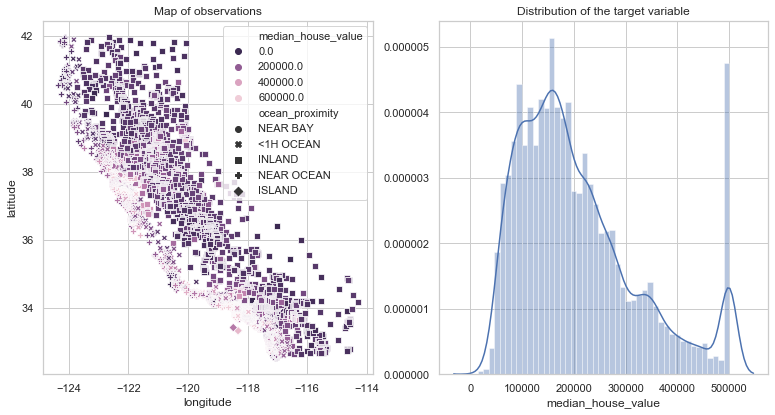

In [3]:
sb.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13,6.5))
sb.scatterplot(x="longitude", y="latitude",
                hue="median_house_value", style="ocean_proximity",
                palette="ch:r=.3,d=.2_r", 
                data=dataset, legend = "brief", ax = ax1)
sb.distplot(dataset['median_house_value'], ax = ax2)
ax1.set_title("Map of observations")
ax2.set_title("Distribution of the target variable")

In [4]:
#exclude luxury house market
dataset = dataset.loc[dataset.median_house_value < 500000]

Moreover, 200 observations have a NaN value in the place of the number of bedrooms. Since they represent approximately 1% of the observations, it is reasonable to exclude them altogether, resulting in a dataset of 19448 tuples.

At this point, numeric variables can be standardized so that they have null mean and unitary variance, whereas the categorical one can be converted into 5 dummies (one for each value in its domain). Only 4 out of 5 will be used in the regression, since the fifth one will certainly be collinear with the others. By arbitrary decision, the dummy for \textit{ocean proximity = ISLAND} will be excluded. The result of previous operations is exemplified in the following table, again showing the first instances of the dataset.

In [5]:
#exclude NaN values
dataset = dataset.dropna()

In [6]:
#standardize numeric variables

for j in dataset.columns:
    if isinstance(dataset.loc[0,j], (float, int)):
        dataset[j] = (dataset[j] - dataset[j].mean())/dataset[j].std()

In [7]:
dummies = pd.get_dummies(dataset.ocean_proximity)
ocean_prox = dataset.pop('ocean_proximity')

dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

In [8]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.329343,1.035347,1.009994,-0.796474,-0.971821,-0.977307,-0.978519,2.961763,2.683772,0,0,0,1,0
1,-1.324357,1.026047,-0.588694,2.048480,1.340315,0.838681,1.661474,2.946599,1.714624,0,0,0,1,0
2,-1.334328,1.021397,1.889272,-0.527944,-0.827460,-0.825320,-0.845476,2.281460,1.648709,0,0,0,1,0
3,-1.339313,1.021397,1.889272,-0.616234,-0.720965,-0.771163,-0.735911,1.252979,1.537479,0,0,0,1,0
4,-1.339313,1.021397,1.889272,-0.454750,-0.614469,-0.765049,-0.631563,0.108162,1.546748,0,0,0,1,0


In [9]:
data = dataset.copy(deep=True)

### 3. ANALYSIS

After pre-processing operations (elimination of NaN and weird values, standardization, definition of dummy variables), it is time to start the analysis. 

To begin with, the presence of multicollinearity issues was checked. The correlation matrix clearly highlights the collinearity between longitude and latitude (due to the peculiar shape of California territory), as well as among the number of rooms, bedrooms, inhabitants and households.

In [10]:
island = data.pop('ISLAND')
y = data.pop('median_house_value')
C = data.drop(columns = ['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']).cov()

Text(0.5, 1, 'Correlation matrix for numeric variables')

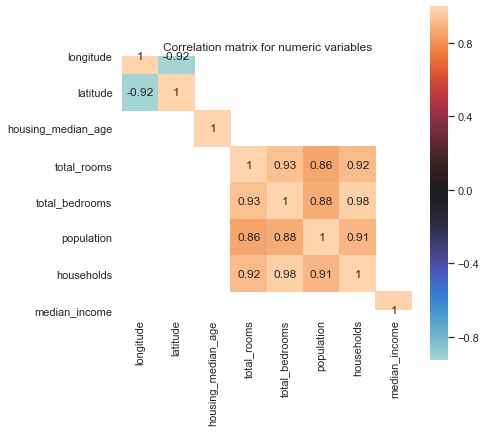

In [11]:
f, ax = plt.subplots(figsize=(6.5,6.5))
sb.heatmap(C, center = 0, annot=True, square = True, mask = C.abs()<0.8, ax=ax)
ax.set_title("Correlation matrix for numeric variables")

Variance Inflation Factors of numeric features were computed in order to verify these impressions. The following plot shows that the highest VIFs were found for the number of bedrooms and the number of households, which have been subsequently excluded from the regression framework. Among dummies that replaced the categorical variable, the one indicating \textit{ocean_proximity = ISLAND} was eliminated, as it would surely be collinear with the other 4.

In [12]:
#define a function that computes VIFs
#X must be a Pandas data frame

def VIF(X):
    X = (X - X.mean(axis=0))/X.std(axis=0)
    vif = []
    for j in X.columns:
        yj = np.array(X[j])
        Xj = np.matrix(X.drop(columns = [j]))
        beta = np.linalg.inv(Xj.T @ Xj) @ Xj.T @ yj
        residuals = yj - Xj @ np.reshape(np.asarray(beta), newshape=-1)
        RSS = np.square(residuals).sum()
        vif.append(np.var(yj, ddof = len(yj)-1)/RSS)
        
    vif = pd.Series(vif, index = X.columns)
    return vif

Text(0.5, 1.0, 'Variance Inflation Factors for numeric variables')

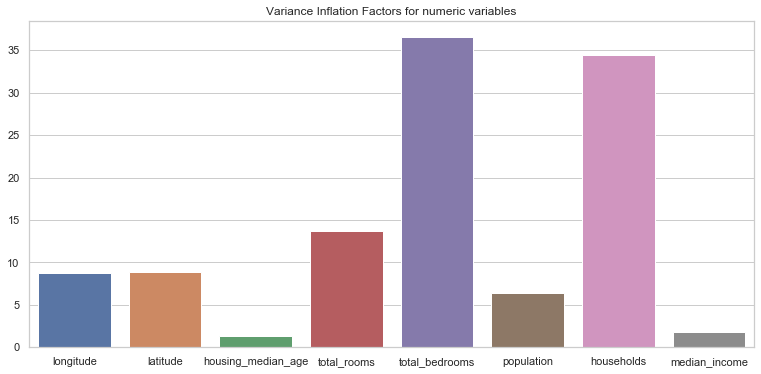

In [13]:
vifs = pd.DataFrame(VIF(data.drop(columns = ['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN'])))
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 6))
sb.barplot(data = vifs.T)
ax.set_title("Variance Inflation Factors for numeric variables")

In [14]:
data = data.drop(columns = ['total_bedrooms', 'households'])

It is now possible to perform the regression and turn to the analysis of the stability-accuracy tradeoff. In this context, cross-validation is useful to define both the error and its variance: as stated in the introduction, here the $R^{2}$ coefficient is used to evaluate accuracy on each training fold and the MSE on each test fold; the results are then averaged across folds and their empirical variances are used as proxies to address stability. 

One aspect that is worth noticing in this approach is that increasing the number of folds $K$ reduces the however low empirical variance of the $R^{2}$, because training folds overlap more, but it also increases MSE empirical variance. The graphs below, in which the explicit formula $\mathbf{\hat{w}} = (\mathbf{X^{\intercal}X} +  \alpha m \mathbf{I})^{-1} \mathbf{X^{\intercal}y}$ was used to compute the predictor, can be considered almost on a par with learning curves, as increasing the number of folds corresponds to enlarging the training set. They show that both test error and training accuracy stay almost constant when $K$ varies, and they confirm that the deviation of the former clearly increases whereas that of the latter tends to decrease. 


In [15]:
#define a function that computes K-fold CV MSE for a Ridge regression model on data X and target variable y
#X must be a Pandas data frame, y a Pandas series, K an integer and alpha a real number

def ridge_cv(K, alpha, X, y):
    
    y.index = X.index
    p = X.shape[1]
    
    #create a series with values randomly extracted from U{0,...,K-1} and indices equal to row indices of data
    folds = np.random.randint(low = 0, high = K, size = y.shape)
    folds = pd.Series(folds, index = y.index)
    
    #initialize lists for regression coefficients, MSE, R2 and observations per fold
    coef = []
    MSE = []
    R2 = []
    nk = []
    
    #for cycle --> training on K-1 folds and testing on the remaining 1
    for k in range(K):
        X_train = np.array(X.loc[folds != k, :])
        y_train = np.array(y.loc[folds != k])
        X_test = np.array(X.loc[folds == k, :])
        y_test = np.array(y.loc[folds == k])
        nk.append(X_test.shape[0])
        
        m = X_train.shape[0]
        
        # w = (X'X + aI)^(-1)*X'y  on the training set
        XX = X_train.T @ X_train + np.diag(np.full(shape = p, fill_value = alpha*m))
        beta = np.linalg.inv(XX) @ X_train.T @ y_train
        beta = np.reshape(np.asarray(beta), newshape=-1)
        coef.append(beta)
        
        # R2 = 1 - RSS/TSS
        residuals = y_train - X_train @ beta
        RSS = np.square(residuals).sum()
        TSS = np.var(y_train, ddof = len(y_train)-1)
        R2.append(1 - RSS/TSS)
        
        # MSE = (1/n)*||Xw - y||^2  on the test set
        msqerr = np.mean(np.square(y_test - X_test @ beta))
        MSE.append(msqerr)
        
        
    #transform lists into matrices and arrays to make operations on them
    coef = np.array(coef)
    MSE = np.array(MSE)
    R2 = np.array(R2)
    nk = np.array(nk)
    
    #take the weighted averages and the variances
    w = np.average(coef, axis = 0, weights = nk)
    w = pd.Series(w, index = X.columns)

    mean_MSE = np.average(MSE, weights = nk)
    
    MSE_var = np.average(np.square(MSE - mean_MSE), weights = nk)
    
    mean_R2 = np.average(R2, weights = nk)
    
    R2_var = np.average(np.square(R2 - mean_R2), weights = nk)
    
    return w, mean_MSE, MSE_var, mean_R2, R2_var

In [16]:
run = range(3,21)
MSE_mean_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[1] for k in run])
R2_mean_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[3] for k in run])
MSE_var_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[2] for k in run])
R2_var_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[4] for k in run])

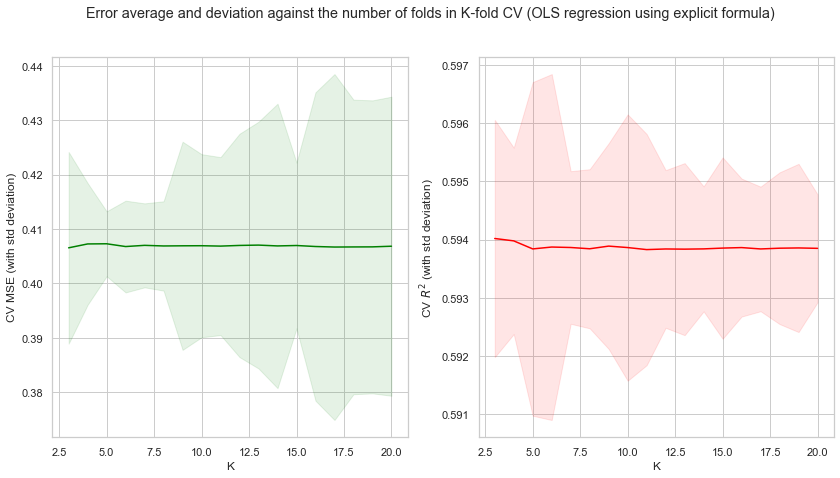

In [17]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(run, MSE_mean_K, color="green")
ax1.fill_between(run, MSE_mean_K - np.sqrt(MSE_var_K), MSE_mean_K + np.sqrt(MSE_var_K), alpha=0.1, color="green")
ax1.set_xlabel("K")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(run, R2_mean_K, color="red")
ax2.fill_between(run, R2_mean_K - np.sqrt(R2_var_K), R2_mean_K + np.sqrt(R2_var_K), alpha=0.1, color="red")
ax2.set_xlabel("K")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

f.suptitle("Error average and deviation against the number of folds in K-fold CV (OLS regression using explicit formula)")

plt.show()

This behavior is confirmed also when the predictor is computed by batch gradient descent instead of explicit formula. Here, gradient descent was applied with constant learning rate $\eta = 0.25$, as the algorithm diverged in case $\eta = 0.5$ and converged slowly in case $\eta = 0.1$, and precision $\epsilon = 0.01$. This parameter, together with the maximum number of iterations (here set to 1000), shapes the break rule of the algorithm:

$\| \nabla l_{S}(\mathbf{w}) \|= \| \frac{2}{m} \mathbf{X^{\intercal}(Xw - y)} \| < \epsilon$

Again the graphs show constant errors, increasing test error variance and decreasing training error variance. Notice that the confidence intervals are slightly narrower than the ones found by the explicit formula, meaning that the application of gradient descent on different folds outputs more similar coefficients.

As error empirical variances in the cross validation framework look more or less constant after $K=10$, such value will be used from now on.

In [18]:
## Batch Gradient Descent
## since F(w)=mean(w'x - y)^2 + alpha*||w||^2
##   --> grad(F(w)) = 2mean(w'x - y)x + 2*alpha*w
##    --> w(t+1) = w(t) - eta*grad(F(w))


def sgd_ridge(precision, X, y, eta, alpha):
    distance = precision + 1
    m = X.shape[0]
    p = X.shape[1]
    w = np.zeros(p)
    it = 0
    
    while distance > precision and it < 1000:
        grad = 2*alpha*w + (2/m)*(X.T @ (X @ w - y))
        w += -eta*grad
        it += 1
        
        distance = (2/m)*np.linalg.norm(X.T @ (X @ w - y))
        
    return w

In [19]:
## another version, using batch gradient descent instead of the explicit formula. 

def ridge_cv_sgd(K, alpha, eta, X, y):
    
    y.index = X.index
    p = X.shape[1] #number of features
    
    #create a series with values randomly extracted from U{0,...,K-1} and indices equal to row indices of data
    folds = np.random.randint(low = 0, high = K, size = y.shape)
    folds = pd.Series(folds, index = y.index)
    
    #initialize lists for regression coefficients, standard errors, MSE, R2 and observations per fold
    coef = []
    MSE = []
    R2 = []
    nk = []
    
    #for cycle --> training on K-1 folds and testing on the remaining 1
    for k in range(K):
        X_train = np.array(X.loc[folds != k, :])
        y_train = np.array(y.loc[folds != k])
        X_test = np.array(X.loc[folds == k, :])
        y_test = np.array(y.loc[folds == k])
        nk.append(X_test.shape[0])
        
        # Stochastic gradient descent on the training set, with precision 0.001
        w = sgd_ridge(precision = 0.01, X = X_train, y = y_train, eta = eta, alpha = alpha)
        coef.append(w)
        
        # R2 = 1 - RSS/TSS
        residuals = y_train - X_train @ w
        RSS = np.square(residuals).sum()
        TSS = np.var(y_train, ddof = len(y_train)-1)
        R2.append(1 - RSS/TSS)
        
        # MSE = (1/n)*||Xw - y||^2  on the test set
        msqerr = np.mean(np.square(y_test - X_test @ w))
        MSE.append(msqerr)
        
        
    #transform lists into matrices and arrays to make operations on them
    coef = np.array(coef)
    MSE = np.array(MSE)
    R2 = np.array(R2)
    nk = np.array(nk)
    
    #take the weighted averages and the variances
    w = np.average(coef, axis = 0, weights = nk)
    w = pd.Series(w, index = X.columns)
    
    mean_MSE = np.average(MSE, weights = nk)
    
    MSE_var = np.average(np.square(MSE - mean_MSE), weights = nk)
    
    mean_R2 = np.average(R2, weights = nk)
    
    R2_var = np.average(np.square(R2 - mean_R2), weights = nk)
    
    return w, mean_MSE, MSE_var, mean_R2, R2_var

In [20]:
run = range(3,21)
MSE_mean_K = np.array([ridge_cv_sgd(K=k, alpha=0, X=data, y=y, eta=0.25)[1] for k in run])
R2_mean_K = np.array([ridge_cv_sgd(K=k, alpha=0, X=data, y=y, eta=0.25)[3] for k in run])
MSE_var_K = np.array([ridge_cv_sgd(K=k, alpha=0, X=data, y=y, eta=0.25)[2] for k in run])
R2_var_K = np.array([ridge_cv_sgd(K=k, alpha=0, X=data, y=y, eta=0.25)[4] for k in run])

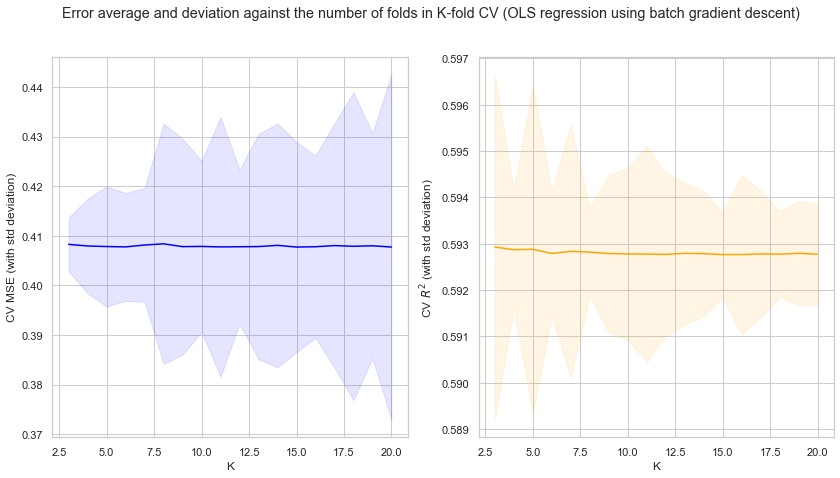

In [21]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(run, MSE_mean_K, color="blue")
ax1.fill_between(run, MSE_mean_K - np.sqrt(MSE_var_K), MSE_mean_K + np.sqrt(MSE_var_K), alpha=0.1, color="blue")
ax1.set_xlabel("K")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(run, R2_mean_K, color="orange")
ax2.fill_between(run, R2_mean_K - np.sqrt(R2_var_K), R2_mean_K + np.sqrt(R2_var_K), alpha=0.1, color="orange")
ax2.set_xlabel("K")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

f.suptitle("Error average and deviation against the number of folds in K-fold CV (OLS regression using batch gradient descent)")

plt.show()

Now that multicollinearity issues have been tackled and the number of folds for cross validation has been chosen, the time has come to introduce the regularization term and examine the behavior of errors and their variances when parameter $\alpha$ changes. Again the results will be obtained by two different methods (the explicit formula and batch gradient descent) and then compared.

As expected, both results agree on the fact that greater $\alpha$ produce lower accuracy on the training set, with an $R^{2}$ dropping from almost 60% to little more than 40%, and that also test error rises from an average of 0.4 to 0.6. Considering that the variance of the target variable has been normalized to 1 and that $R^{2} = 1 - \frac{\sum_{t=1}^{m} (y_{t}-\mathbf{w^{\intercal}x_{t}})^{2}}{\sum_{t=1}^{m} (y_{t}-\overline{y})^2} \approx 1 - MSE_{Train}$, the training and test errors follow very similar paths. The model clearly underfits as $\alpha \rightarrow 1$ and the monotonic worsening of test error indicates that $\nexists \alpha \in ]0;1[$ that minimizes it. 

Error standard deviation, which was expected to shrink as $\alpha$ rose, remains in facts almost constant, at least in a range of $\alpha$ from 0 to 1 and except for noisy fluctuations. Also underestimation of training error variance can be seen from the following graph, by comparison with test error variance. One possible interpretation for the absent improvement in error deviation is that the linear model may underfit in any case. Indeed, the $R^{2}$ coefficient never reaches 60%. Ridge regression doesn't bring any improvement from this perspective and other models might be tried. 

In [22]:
alpha_run = [0]
for i in range(100):
    alpha_run.append(alpha_run[i]+0.01)

In [23]:
#plot CV MSE against alpha

MSE_mean_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[1] for a in alpha_run]
MSE_var_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[2] for a in alpha_run]
R2_mean_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[3] for a in alpha_run]
R2_var_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[4] for a in alpha_run]

In [24]:
MSE_mean_alpha_gd = []
MSE_var_alpha_gd = []
R2_mean_alpha_gd = []
R2_var_alpha_gd = []

for a in alpha_run:
    w, mse, msevar, r2, r2var = ridge_cv_sgd(K=10, alpha = a, X = data, y = y, eta = 0.2)
    MSE_mean_alpha_gd.append(mse)
    MSE_var_alpha_gd.append(msevar)
    R2_mean_alpha_gd.append(r2)
    R2_var_alpha_gd.append(r2var)


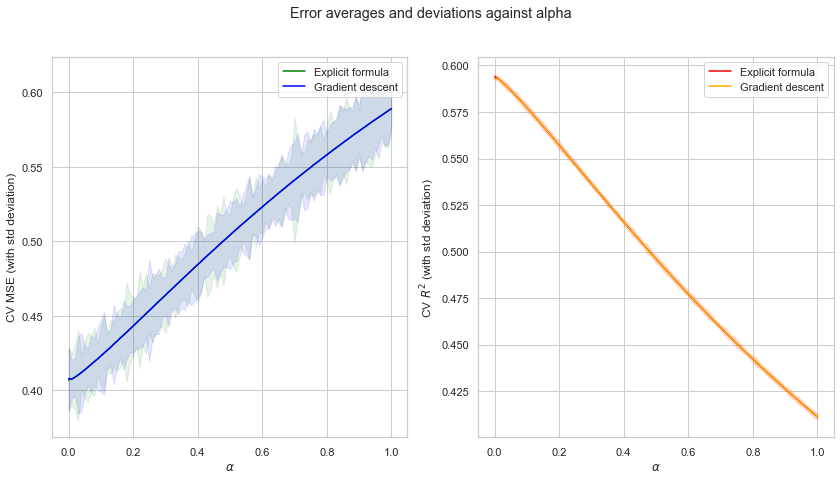

In [25]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

mse_ex_plot, = ax1.plot(alpha_run, MSE_mean_alpha, color="green")
ax1.fill_between(alpha_run, MSE_mean_alpha - np.sqrt(MSE_var_alpha), MSE_mean_alpha + np.sqrt(MSE_var_alpha), alpha=0.1, color="green")
mse_ex_plot.set_label("Explicit formula")
mse_gd_plot, = ax1.plot(alpha_run, MSE_mean_alpha_gd, color="blue")
ax1.fill_between(alpha_run, MSE_mean_alpha_gd - np.sqrt(MSE_var_alpha_gd), MSE_mean_alpha_gd + np.sqrt(MSE_var_alpha_gd), alpha=0.1, color="blue")
mse_gd_plot.set_label("Gradient descent")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CV MSE (with std deviation)")
ax1.legend()

r2_ex_plot, = ax2.plot(alpha_run, R2_mean_alpha, color="red")
ax2.fill_between(alpha_run, R2_mean_alpha - np.sqrt(R2_var_alpha), R2_mean_alpha + np.sqrt(R2_var_alpha), alpha=0.1, color="red")
r2_ex_plot.set_label("Explicit formula")
r2_gd_plot, = ax2.plot(alpha_run, R2_mean_alpha_gd, color="orange")
ax2.fill_between(alpha_run, R2_mean_alpha_gd - np.sqrt(R2_var_alpha_gd), R2_mean_alpha_gd + np.sqrt(R2_var_alpha_gd), alpha=0.1, color="orange")
r2_gd_plot.set_label("Gradient descent")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")
ax2.legend()

f.suptitle("Error averages and deviations against alpha")
plt.show()

We may visualize the difference between OLS prediction and Ridge prediction using the following graph, which compares predicted values and empirical values for the target variable. It may be noticed that Ridge regression tends to shrink predictions towards the mean, and it performs evidently worse than OLS over the whole dataset.

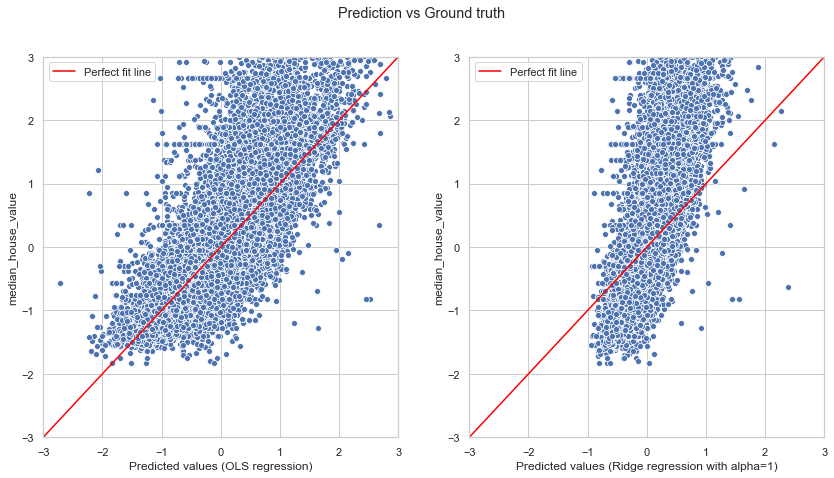

In [32]:
w_ols = ridge_cv(K=10, alpha=0, X = data, y = y)[0]
w_ridge = ridge_cv(K=10, alpha=1, X = data, y = y)[0]
sb.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14,7))

sb.scatterplot(x = data @ w_ols, y = y, ax = ax1)
t = np.linspace(-3, 3, num = 1000)
pft_line_ols, = ax1.plot(t, t, color = 'red')
pft_line_ols.set_label("Perfect fit line")
ax1.set_xlabel("Predicted values (OLS regression)")
ax1.set_xlim(xmin=-3,xmax=3)
ax1.set_ylim(ymin=-3,ymax=3)
ax1.legend()

sb.scatterplot(x = data @ w_ridge, y = y, ax = ax2)
pft_line_ridge, = ax2.plot(t, t, color = 'red')
pft_line_ridge.set_label("Perfect fit line")
ax2.set_xlabel("Predicted values (Ridge regression with alpha=1)")
ax2.set_xlim(xmin=-3,xmax=3)
ax2.set_ylim(ymin=-3,ymax=3)
ax2.legend()

f.suptitle("Prediction vs Ground truth")
plt.show()

##### Dimension Reduction

As stated in the introduction, another objective of the present analysis is to verify the effects of dimension reduction on the regression performance. 

Since the dataset contains both qualitative and quantitative variables, Principal Component Analysis is not appropriate by itself, unless the only categorical feature was considered as supplementary. Leaving this alternative approach for later, I start by applying Factor Analysis of Mixed Data, a particular technique that combines PCA with Multiple Correspondence Analysis. 

The dataset, which now contains all the initial numeric variables and the 5 dummies, must first be randomly splitted into a training and a test set. Since we have seen in the cross validation framework that error estimates are quite stable over different folds (average dispersion, or variance-to-mean ratio, is 0.1% for test error and far lower for training error), cross validation isn't used in this part of the analysis. Instead, 75% of the observations, amounting to 14642 randomly drawn tuples, is allocated into the training set, whereas the remaining 25% is used for validation. 

Since in principle test data are unknown, the principal directions that stem from dimension reduction are computed using only the training data. Let's start from Factor Analysis of Mixed Data. In this technique, dummy variables must first be transformed to fit PCA: more precisely, each of them is divided by the number of its occurrences and is then standardized. PCA is applied to the resulting data frame, leading to the definition of 13 principal components with their associated eigenvalues, which represent the proportion of variance explained by each component $PVE_{j} = \frac{\lambda _{j}}{\sum_{i=1}^{13} \lambda _{i}}$, $j=1,...,13$.

The cumulative screeplot in figure is a simple representation of the growth of PVE when new directions are added. Here it can be noticed that the variance explained by the first 2 principal components amounts to less than 50%, meaning that these directions are generally inappropriate to explain the distribution of data by themselves. At least 5 components would indeed be needed to reach 80%.

In [50]:
test_dispersion=np.array(MSE_var_alpha)/ np.array(MSE_mean_alpha)
training_dispersion=np.array(R2_var_alpha)/ np.array(R2_mean_alpha)

In [68]:
train_test_split = np.random.binomial(n = 1,p = 0.75, size = dataset.shape[0])
train_data = dataset.loc[train_test_split==1, :]
test_data = dataset.loc[train_test_split != 1, :]
y_train = train_data.pop("median_house_value")
y_test = test_data.pop("median_house_value")

In [69]:
for col in train_data.loc[:, '<1H OCEAN':'NEAR OCEAN'].columns:
    train_data[col] = train_data[col] / train_data[col].sum()
    train_data[col] = (train_data[col] - train_data[col].mean()) / train_data[col].std()


C:\Users\DavideR\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DavideR\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
C = train_data.T @ train_data
lamb, V = np.linalg.eig(C.values)

Text(0.5, 0.98, 'FAMD cumulative PVE')

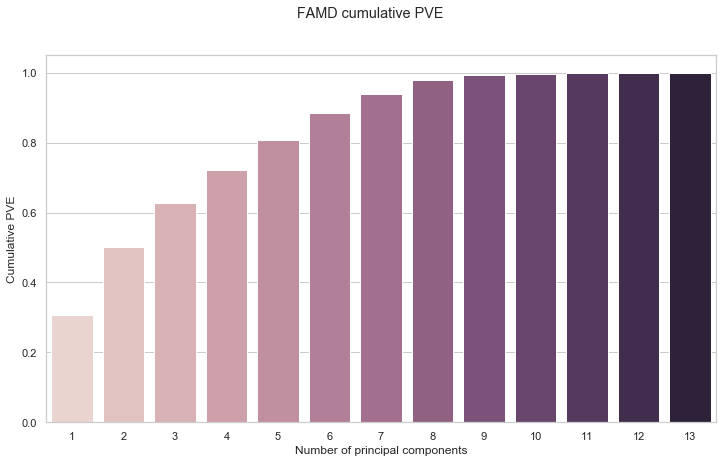

In [71]:
#cumulative screeplot
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12,6.75))
t = np.arange(1, len(lamb)+1)
sb.barplot(x=t, y=np.cumsum(lamb)/np.sum(lamb), palette=sb.cubehelix_palette(len(lamb)))
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative PVE")
f.suptitle("FAMD cumulative PVE")

Despite being poor in explained variance, the first 2 principal directions are easily interpretable: the first one is negatively correlated with population, the number of rooms, bedrooms and households, but it is positively correlated with housing age, so it is possible to think about a dichotomy between new blocks of large houses (low value of this component) and old blocks of small ones (high value of this component); the second, instead, is almost purely geographical, longitude and local dummies having the highest absolute loadings: the South-East area presents high values in this direction, whereas the North-West presents low ones. Curiously, median income, the most relevant variable in previous models, has low correlation with both directions, thus suggesting that dimension reduction won't yield better results.

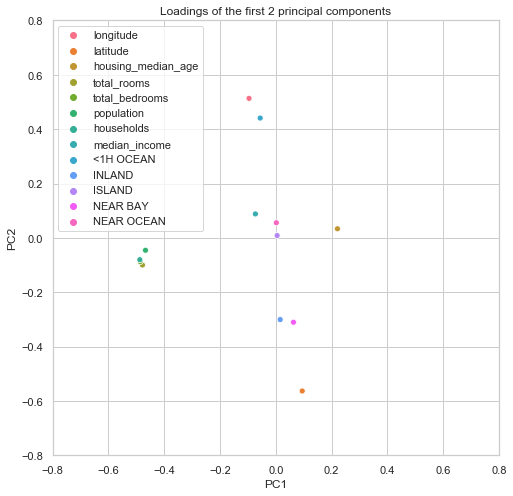

In [72]:
#loadings of the first 2 principal components
two_pc = V[:,:2]
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8,8))
sb.scatterplot(x = two_pc[:,0], y = two_pc[:,1], hue = train_data.columns, ax=ax)
ax.legend(loc=2)
ax.set_title("Loadings of the first 2 principal components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
plt.show()

Quite the opposite, a clear worsening is visible. The test MSE rises by 0.44 on average, more than doubling for low $\alpha$,  and the $R^{2}$ deteriorates from an average of 51% to almost 5%. Both the computations (by explicit formula and by batch gradient descent) confirm the deterioration, which could be forecasted from the low PVEs of the two principal components in FAMD. The aforementioned absence of the most relevant feature from the two directions and therefore from the regression obviously plays a big role in this finding.

In [76]:
def ridge_pca(alpha, pc_load, X_train, y_train, X_test, y_test):
    
    m = X_train.shape[0]
    p = pc_load.shape[1]
    
    train_scores = X_train.values @ pc_load
    
        # w = (X'X + amI)^(-1)*X'y  on the training set
    XX = train_scores.T @ train_scores + np.diag(np.full(shape = p, fill_value = alpha*m))
    w = np.linalg.inv(XX) @ train_scores.T @ y_train
           
        # R2 = 1 - RSS/TSS
    residuals = y_train - train_scores @ w
    RSS = np.square(residuals).sum()
    TSS = np.var(y_train, ddof = len(y_train)-1)
    R2 = 1 - RSS/TSS
        
        # MSE = (1/n)*||Xw - y||^2  on the test set
    test_scores = X_test.values @ pc_load
    MSE = np.mean(np.square(y_test - test_scores @ w))
              
    return w, MSE, R2

In [78]:
def ridge_pca_gd(alpha, eta, pc_load, X_train, y_train, X_test, y_test):
    
    m = X_train.shape[0]
    p = pc_load.shape[1]
    
    train_scores = X_train.values @ pc_load
    
        # w = (X'X + amI)^(-1)*X'y  on the training set
    w = sgd_ridge(precision = 0.01, X = train_scores, y = y_train, eta = eta, alpha = alpha)
           
        # R2 = 1 - RSS/TSS
    residuals = y_train - train_scores @ w
    RSS = np.square(residuals).sum()
    TSS = np.var(y_train, ddof = len(y_train)-1)
    R2 = 1 - RSS/TSS
        
        # MSE = (1/n)*||Xw - y||^2  on the test set
    test_scores = X_test.values @ pc_load
    MSE = np.mean(np.square(y_test - test_scores @ w))
              
    return w, MSE, R2

In [82]:
MSE_alpha = []
MSE_alpha_gd = []
R2_alpha = []
R2_alpha_gd = []

for a in alpha_run:
    w, mse, r2 = ridge_pca(alpha = a, pc_load = two_pc, X_train = train_data, y_train = y_train, X_test = test_data, y_test = y_test)
    MSE_alpha.append(mse)
    R2_alpha.append(r2)
    w_gd, mse_gd, r2_gd = ridge_pca_gd(alpha = a, eta = 0.2, pc_load = two_pc, X_train = train_data, y_train = y_train, X_test = test_data, y_test = y_test)
    MSE_alpha_gd.append(mse_gd)
    R2_alpha_gd.append(r2_gd)

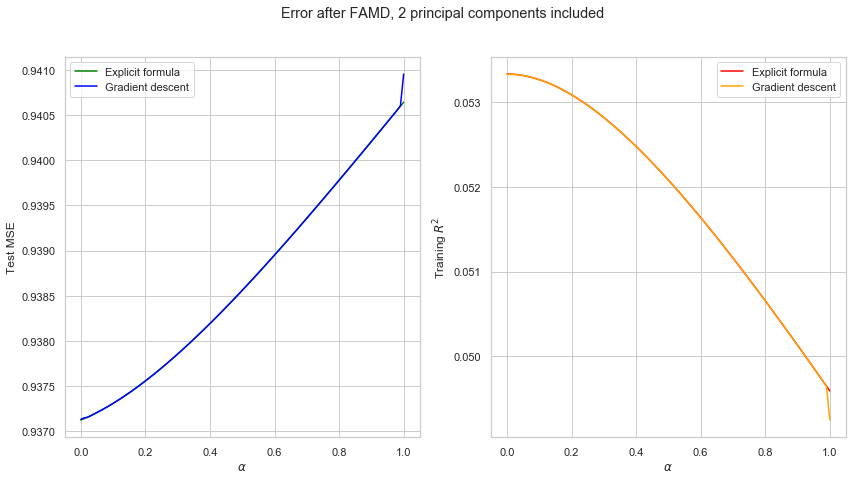

In [86]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

mse_ex_plot, = ax1.plot(alpha_run, MSE_alpha, color="green")
mse_ex_plot.set_label("Explicit formula")
mse_gd_plot, = ax1.plot(alpha_run, MSE_alpha_gd, color="blue")
mse_gd_plot.set_label("Gradient descent")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Test MSE")
ax1.legend()

r2_ex_plot, = ax2.plot(alpha_run, R2_alpha, color="red")
r2_ex_plot.set_label("Explicit formula")
r2_gd_plot, = ax2.plot(alpha_run, R2_alpha_gd, color="orange")
r2_gd_plot.set_label("Gradient descent")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("Training " + r"$R^{2}$")
ax2.legend()

f.suptitle("Ridge regression error after FAMD, 2 principal components included")
plt.show()

Although dimension reduction yields poor results, an alternative approach is also tried. In fact, the categorical variable can be considered as supplementary, while leaving quantitative features as the only active ones. If the scores obtained throught PCA were clearly clusterable into the 5 geographical areas, then the categories may be explainable in terms of the other variables and PCA may therefore be the correct approach. In particular, principal directions would have higher PVEs, thus improving their representativity of data.

The graphs below show that the cumulative PVE of the 2 principal components indeed rises from less than 50% to more than 70%, although the third component is needed to reach 80%. Nevertheless, the scatterplot denies the possibility to clearly allocate training points to geographical clusters, so FAMD on all variables may be preferable to PCA applied only to numeric ones.

In [93]:
#last try: consider qualitative variable as supplementary
C_supp = train_data.loc[:,'longitude':'median_income'].cov()
new_lamb, new_V = np.linalg.eig(C_supp)
indices = np.argsort(new_lamb)
new_lamb = np.sort(new_lamb)[::-1]
new_V = np.array([new_V[i] for i in indices[::-1]])

Text(0.5, 0.98, 'PCA cumulative PVE')

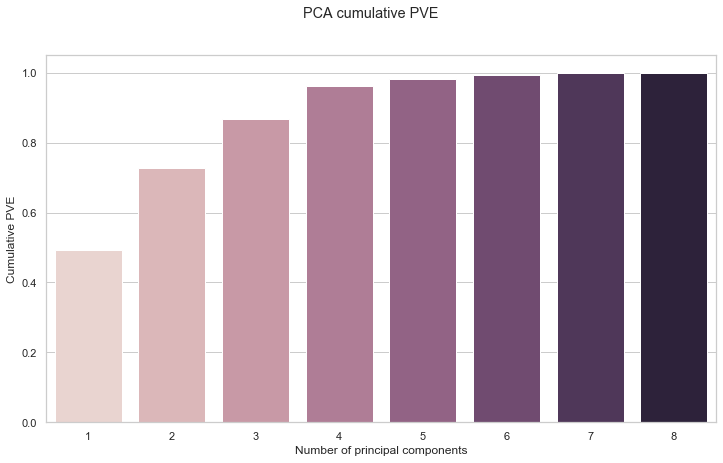

In [98]:
#cumulative screeplot
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12,6.75))
t = np.arange(1, len(new_lamb)+1)
sb.barplot(x=t, y=np.cumsum(new_lamb)/np.sum(new_lamb), palette=sb.cubehelix_palette(len(new_lamb)))
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative PVE")
f.suptitle("PCA cumulative PVE")

In [96]:
new_two_pc = new_V[:,:2]
new_scores = pd.DataFrame(train_data.loc[:,'longitude':'median_income'].values @ new_two_pc)

Text(0.5, 0.98, 'Training data scores from PCA considering qualitative variable as supplementary')

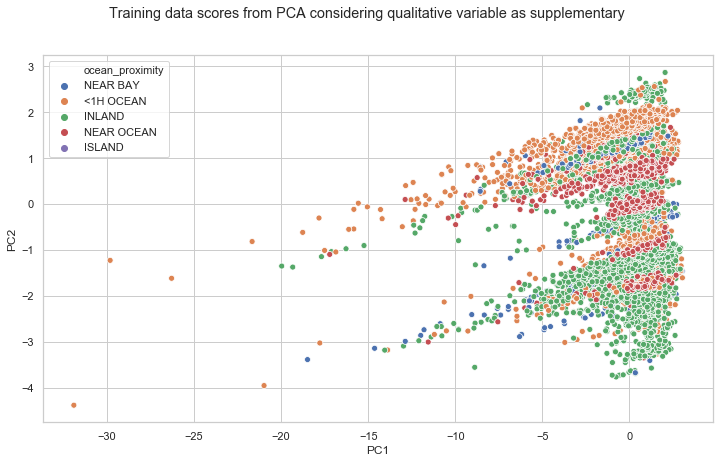

In [99]:
f,ax = plt.subplots(figsize=(12, 6.75))
sb.set(style="whitegrid")
sb.scatterplot(x = new_scores.iloc[:,0], y = new_scores.iloc[:,1], hue = ocean_prox, ax = ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
f.suptitle("Training data scores from PCA considering qualitative variable as supplementary")

However, implementing Ridge regression on the two principal components, whose interpretation is the same as in FAMD, the situation gets even worse, as shown in the following graphs. This result is proof that excluding the categorical variable may well improve PVEs, or better reduce the overall variance to be explained, but it yields poorer results in the regression framework, thus making FAMD clearly preferable despite lower capability to explain variance of data.

In [102]:
new_train_data = dataset.loc[train_test_split==1, 'longitude':'median_income']
new_test_data = dataset.loc[train_test_split != 1, 'longitude':'median_income']

In [103]:
MSE_alpha = []
MSE_alpha_gd = []
R2_alpha = []
R2_alpha_gd = []

for a in alpha_run:
    w, mse, r2 = ridge_pca(alpha = a, pc_load = new_two_pc, X_train = new_train_data, y_train = y_train, X_test = new_test_data, y_test = y_test)
    MSE_alpha.append(mse)
    R2_alpha.append(r2)
    w_gd, mse_gd, r2_gd = ridge_pca_gd(alpha = a, eta = 0.2, pc_load = new_two_pc, X_train = new_train_data, y_train = y_train, X_test = new_test_data, y_test = y_test)
    MSE_alpha_gd.append(mse_gd)
    R2_alpha_gd.append(r2_gd)

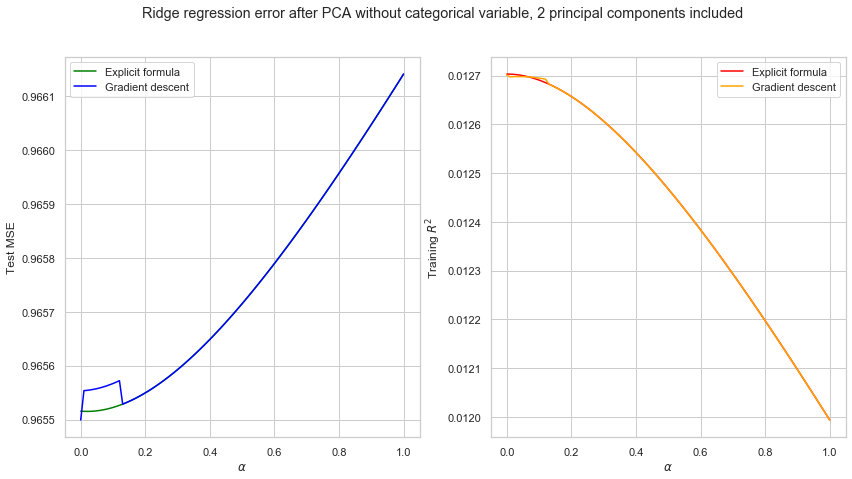

In [104]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

mse_ex_plot, = ax1.plot(alpha_run, MSE_alpha, color="green")
mse_ex_plot.set_label("Explicit formula")
mse_gd_plot, = ax1.plot(alpha_run, MSE_alpha_gd, color="blue")
mse_gd_plot.set_label("Gradient descent")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Test MSE")
ax1.legend()

r2_ex_plot, = ax2.plot(alpha_run, R2_alpha, color="red")
r2_ex_plot.set_label("Explicit formula")
r2_gd_plot, = ax2.plot(alpha_run, R2_alpha_gd, color="orange")
r2_gd_plot.set_label("Gradient descent")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("Training " + r"$R^{2}$")
ax2.legend()

f.suptitle("Ridge regression error after PCA without categorical variable, 2 principal components included")
plt.show()

### 4. CONCLUSIONS

On the basis of the previous analysis, the purposes stated in Section 1 can now be checked and the actual results summarized. In particular, the questions of interest were:

- whether Ridge regression would improve stability and how it would affect accuracy;
- how dimension reduction techniques would impact the regression.

The answer to the first one was negative: little to no change in error variance across folds was observed when varying the regularization parameter $\alpha$. Moreover, both the average MSE on test folds and the average $R^{2}$ on training folds tended to get worse as $\alpha$ increased. A plausible explanation was outlined, mainly based on the low training accuracy: although, in principle, regularization should help avoid overfitting, the linear model may underfit, so a broader class of predictors may be needed. Computations were carried on by two different means, either using the closed-form equation or applying batch gradient descent, and both methods agreed on the results.

As for dimension reduction, Factor Analysis of Mixed Data even worsened the results. In fact, when restricting the regression to the first 2 principal components, accuracy fell sharply both on training and test data, probably due to the fact that those dimensions didn't include the variable that had been identified as the major driver for house value, i.e. the median income within the neighborhood. Notice that here a reverse causality issue may arise, but methods to overcome this bias won't be discussed here. Back to dimension reduction, considering the categorical variable as supplementary and applying PCA only to quantitative ones helped improve the Proportion of Variance Explained by the first 2 principal components, but resulted in further worsening of training and test accuracy. Also in this case the two different methods produced very similar output. 